# Data Extraction

In [5]:
import urllib.request as urllib2
from bs4 import BeautifulSoup
import pandas as pd
import datetime 
import csv

In [6]:
# Data about the crypto to be analized 
coin = 'full_data_XMR_27072020.csv'


In [7]:
# There is no issue with start date, the one that is typed is the first from the BTC but it works for * cryptos 
today = datetime.date.today()
mktcap_page = 'https://coinmarketcap.com/currencies/monero/historical-data/?start=20130428&amp;end='+"{:%Y%m%d}".format(today)
page = urllib2.urlopen(mktcap_page)
soup = BeautifulSoup(page, 'html.parser')
table = soup.find("table")

In [8]:
headings = [th.get_text().strip() for th in table.find("tr").find_all("th")]
headings = [x.replace('*','') for x in headings]
headings

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']

In [9]:
datasets = []

for row in soup.find_all("tr")[1:]:
    dataset = dict(zip(headings, (tr.get_text() for tr in row.find_all("td"))))
    if len(dataset) > 1:
        datasets.append(dataset)

datasets[0]

{'Close': '77.94',
 'Date': 'Jul 26, 2020',
 'High': '78.01',
 'Low': '73.09',
 'Market Cap': '1,375,282,378',
 'Open': '73.46',
 'Volume': '86,834,241'}

In [10]:
my_df = pd.DataFrame(datasets)
full_data = my_df.set_index('Date')
#full_data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']]
full_data.to_csv(coin, index=True, header=True)
full_data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
"Jul 26, 2020",73.46,78.01,73.09,77.94,"86,834,241","1,375,282,378"
"Jul 25, 2020",71.58,73.85,71.50,73.46,"60,151,560","1,296,168,871"
"Jul 24, 2020",72.84,72.99,71.39,71.58,"73,201,966","1,262,847,204"
"Jul 23, 2020",71.47,73.87,70.89,72.86,"82,557,920","1,285,366,161"
"Jul 22, 2020",69.57,71.49,69.34,71.46,"62,044,445","1,260,610,029"


In [11]:
full_data.shape

(2258, 6)

In [12]:
full_data.dtypes

Open          object
High          object
Low           object
Close         object
Volume        object
Market Cap    object
dtype: object

In [13]:
def obj_to_int(x):
    x = x.replace(',','')
    return float(x)
full_data['Low'] = full_data['Low'].apply(obj_to_int)
full_data['High'] = full_data['High'].apply(obj_to_int)
full_data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
"Jul 26, 2020",73.46,78.01,73.09,77.94,"86,834,241","1,375,282,378"
"Jul 25, 2020",71.58,73.85,71.50,73.46,"60,151,560","1,296,168,871"
"Jul 24, 2020",72.84,72.99,71.39,71.58,"73,201,966","1,262,847,204"
"Jul 23, 2020",71.47,73.87,70.89,72.86,"82,557,920","1,285,366,161"
"Jul 22, 2020",69.57,71.49,69.34,71.46,"62,044,445","1,260,610,029"


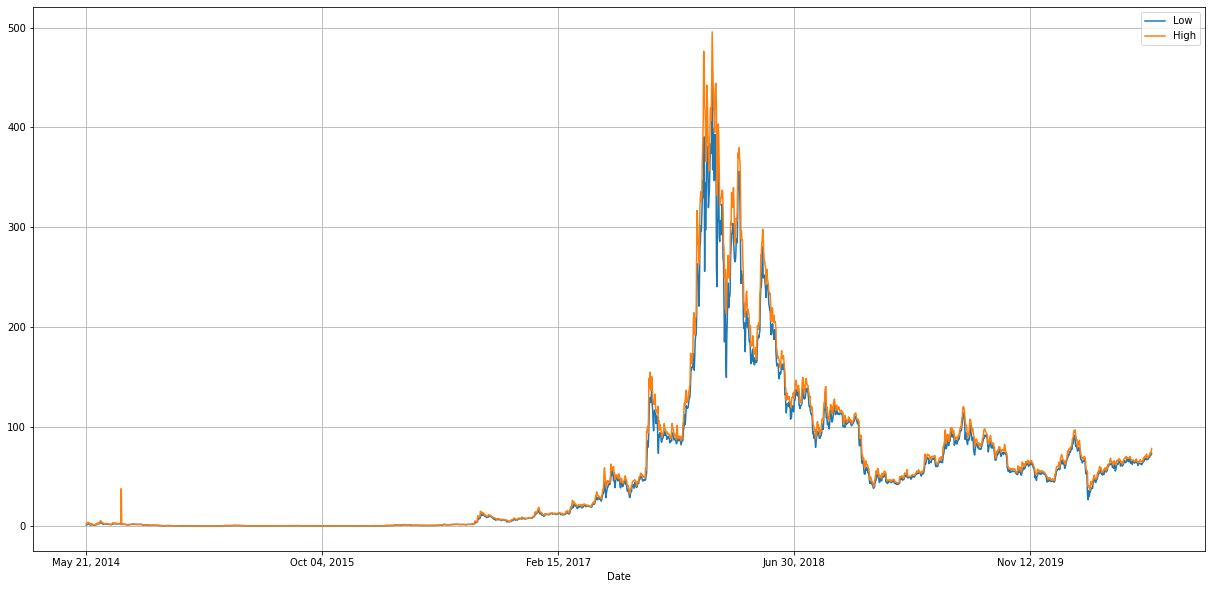

In [14]:
_= full_data[['Low','High']][::-1].plot(grid=True, figsize=(21, 10))

# Preparing data for time series

In [15]:
# This function replaces ',' for nothing and then changes data type object to float

def obj_to_num(df,cols):
    
    def obj_to_num(row):
        if ',' in str(row):
          row = row.replace(',','')
          return float(row)
        else:
          return float(row)

    for col in cols:     
        df[col] = df[col].apply(obj_to_num) 
    return df

# This function changes data column (object) to timestamp[ns] and also can change all dataframe clumns to float 

def prepare_data(file):

  dateparse = lambda x: datetime.datetime.strptime(x, '%b %d, %Y').strftime('%Y-%m-%d')
  data  = pd.read_csv(file, parse_dates=[0], date_parser=dateparse)
  columns = ['Open','High','Low','Close','Volume','Market Cap']
  num_data = obj_to_num(data,columns)
  data['Date'] = data['Date'].dt.tz_localize(None)
  data = data.groupby([pd.Grouper(key='Date', freq='d')]).first().reset_index()
  data = data.set_index('Date')
  data = data[['High','Low']]
  data.dropna(subset=['High','Low'], inplace=True)

  return data

In [23]:
file = coin
data = prepare_data(file)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



,High,Low
Date,,
2014-05-21,2.65,1.23
2014-05-22,2.19,1.36
2014-05-23,3.43,2.05
2014-05-24,4.01,2.62
2014-05-25,4.04,2.80


In [15]:
data.index

DatetimeIndex(['2014-05-21', '2014-05-22', '2014-05-23', '2014-05-24',
               '2014-05-25', '2014-05-26', '2014-05-27', '2014-05-28',
               '2014-05-29', '2014-05-30',
               ...
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26'],
              dtype='datetime64[ns]', name='Date', length=2258, freq=None)

In [16]:
!pip install chart_studio

     |████████████████████████████████| 71kB 4.6MB/s 


In [17]:
import plotly.graph_objects as go
import chart_studio as py

import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [18]:
py.tools.set_credentials_file(username='xxxx', api_key='xxxxx')

In [24]:
trace1 = go.Scatter(
    x = data.index,
    y = data['High'].astype(float),
    mode = 'lines',
    name = 'Monero Price (High)'
)
trace2 = go.Scatter(
    x = data.index,
    y = data['Low'].astype(float),
    mode = 'lines',
    name = 'Monero Price (High)'
)

layout = dict(
    title='Historical monero High price (USD) (...-2020)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2]
fig = dict(data = data.copy(), layout=layout)
py.plotly.iplot(fig, filename = "Time Series with Rangeslider")

# Sarimax Model

## To trade dayli we want to know low and high prices on x number of days the closer the predictions are the more accurate result we have

In [16]:
!pip install pyramid-arima
from pyramid.arima import auto_arima

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr

In [17]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
import matplotlib.pyplot as plt

In [18]:
# We do this again because the fo@#!ing pyplot plot changed data types 
file = coin
data = prepare_data(file)

In [19]:
data.head()

,High,Low
Date,,
2014-05-21,2.65,1.23
2014-05-22,2.19,1.36
2014-05-23,3.43,2.05
2014-05-24,4.01,2.62
2014-05-25,4.04,2.80


In [20]:
data.index

DatetimeIndex(['2014-05-21', '2014-05-22', '2014-05-23', '2014-05-24',
               '2014-05-25', '2014-05-26', '2014-05-27', '2014-05-28',
               '2014-05-29', '2014-05-30',
               ...
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26'],
              dtype='datetime64[ns]', name='Date', length=2258, freq=None)

In [21]:
data_high = pd.DataFrame(data['High'].copy())
data_high.head()

,High
Date,
2014-05-21,2.65
2014-05-22,2.19
2014-05-23,3.43
2014-05-24,4.01
2014-05-25,4.04


In [22]:
decomposition = sm.tsa.seasonal_decompose(data_high)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(data_high, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

ValueError: ignored

In [26]:
# Test for p-value and null hypotesis
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.High)[1])

Dickey–Fuller test: p=0.103705


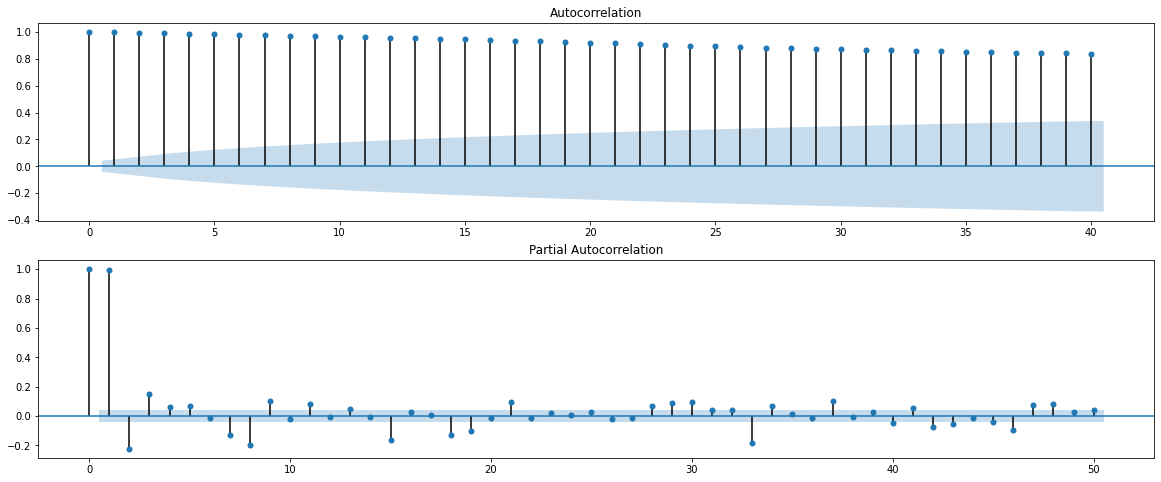

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(20,8))
pyplot.subplot(211)
plot_acf(data.High, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(data.High, ax=pyplot.gca(), lags=50)
pyplot.show()

In [28]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.High, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Dickey–Fuller test:: p=0.000000


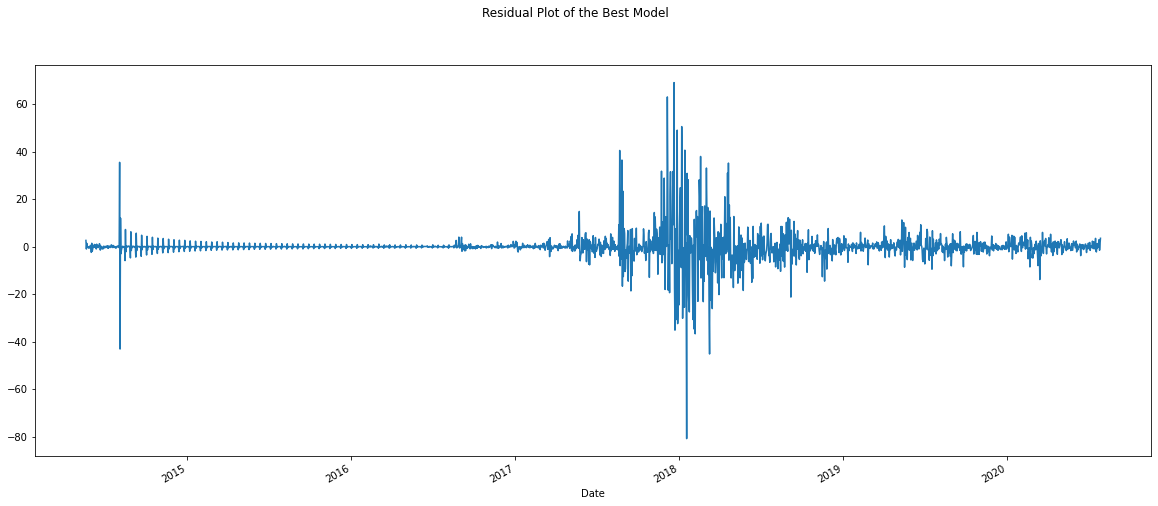

In [29]:
fig = plt.figure(figsize=(20,8))
best_model.resid.plot()
fig.suptitle('Residual Plot of the Best Model')
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

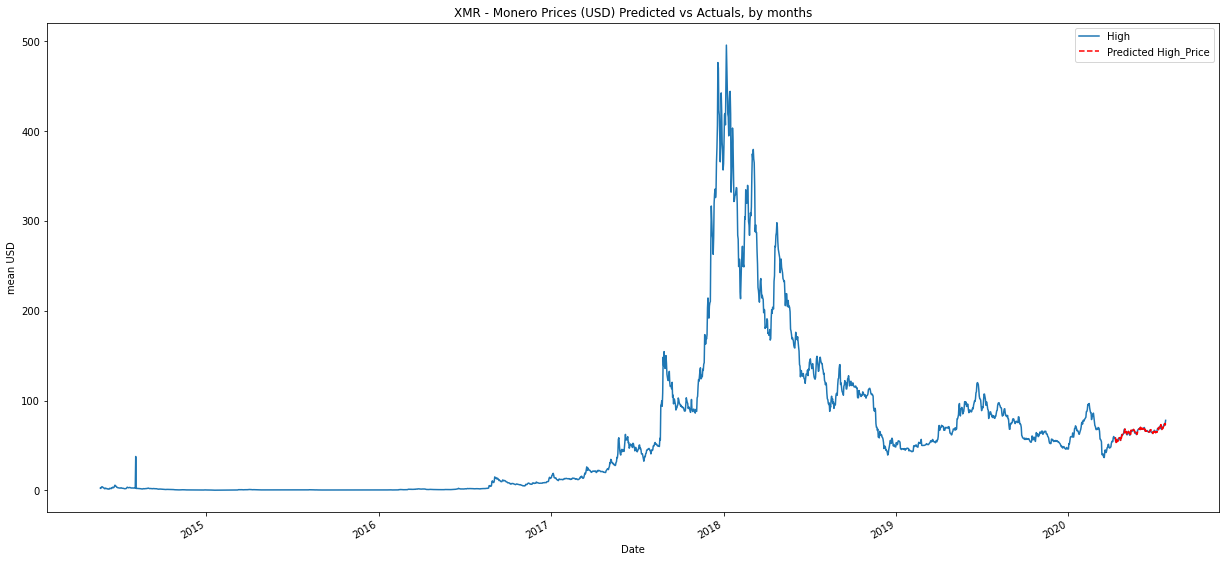

In [38]:
df_month2 = data[['High']]
future = pd.DataFrame()
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=2150, end=2257)
plt.figure(figsize=(21,10))
df_month2.High.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted High_Price')
plt.legend()
plt.title('XMR - Monero Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('mean USD')
plt.show()

In [40]:
df_month2['forecast'] = best_model.predict(start=2237, end=2257)
df_month2[-20:]

,High,forecast
Date,,
2020-07-07,65.07,65.423762
2020-07-08,67.11,64.775085
2020-07-09,68.96,67.374322
2020-07-10,68.33,69.172361
2020-07-11,69.57,67.487010
2020-07-12,70.24,69.970619
2020-07-13,69.93,70.558359
2020-07-14,69.16,70.145949
2020-07-15,72.52,69.006104


In [41]:
# 1795 = 2020-07-06 and 1816 = 2020-07-26 so lets see what would be the price in the next 6 days
best_model.predict(start=2257, end=2262)

2257    74.457540
2258    78.829751
2259    78.418099
2260    77.607404
2261    77.676909
2262    77.958891
dtype: float64